Пример транзакций:
[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'], ['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']]


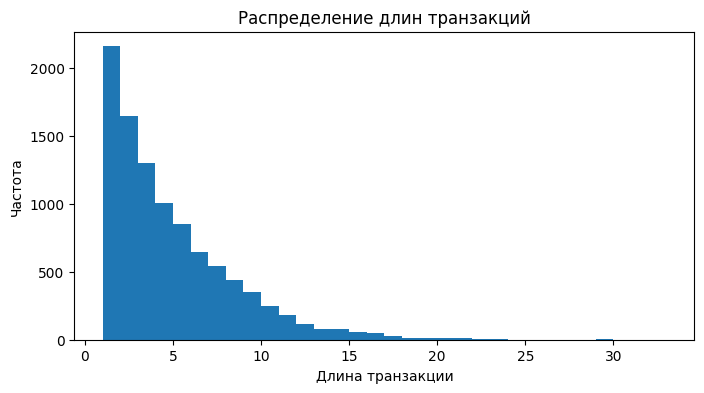

Количество уникальных товаров: 169
Пример товаров: ['Instant food products', 'UHT-milk', 'abrasive cleaner', 'artif. sweetener', 'baby cosmetics', 'baby food', 'bags', 'baking powder', 'bathroom cleaner', 'beef', 'berries', 'beverages', 'bottled beer', 'bottled water', 'brandy', 'brown bread', 'butter', 'butter milk', 'cake bar', 'candles']

=== Частые наборы (FPGrowth) ===
     support                             itemsets
0   0.082766                       (citrus fruit)
1   0.058566                          (margarine)
2   0.139502                             (yogurt)
3   0.104931                     (tropical fruit)
4   0.058058                             (coffee)
..       ...                                  ...
58  0.033249                 (whole milk, pastry)
59  0.047382  (other vegetables, root vegetables)
60  0.048907        (whole milk, root vegetables)
61  0.030605                (sausage, rolls/buns)
62  0.032232     (whipped/sour cream, whole milk)

[63 rows x 2 columns]


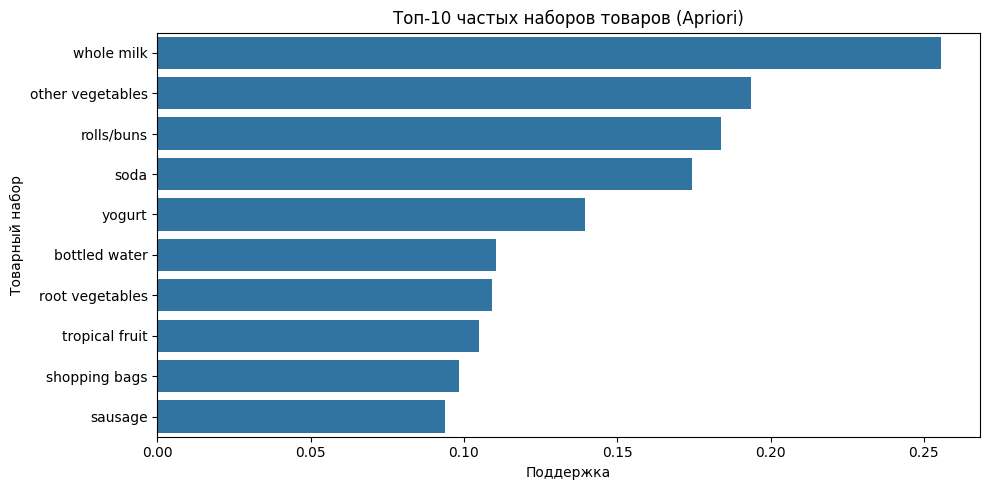

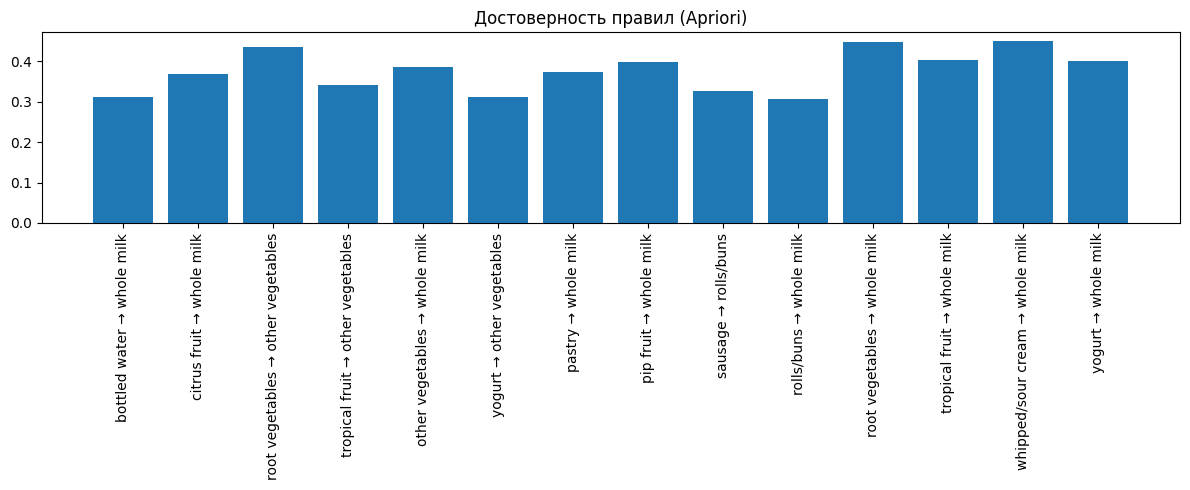

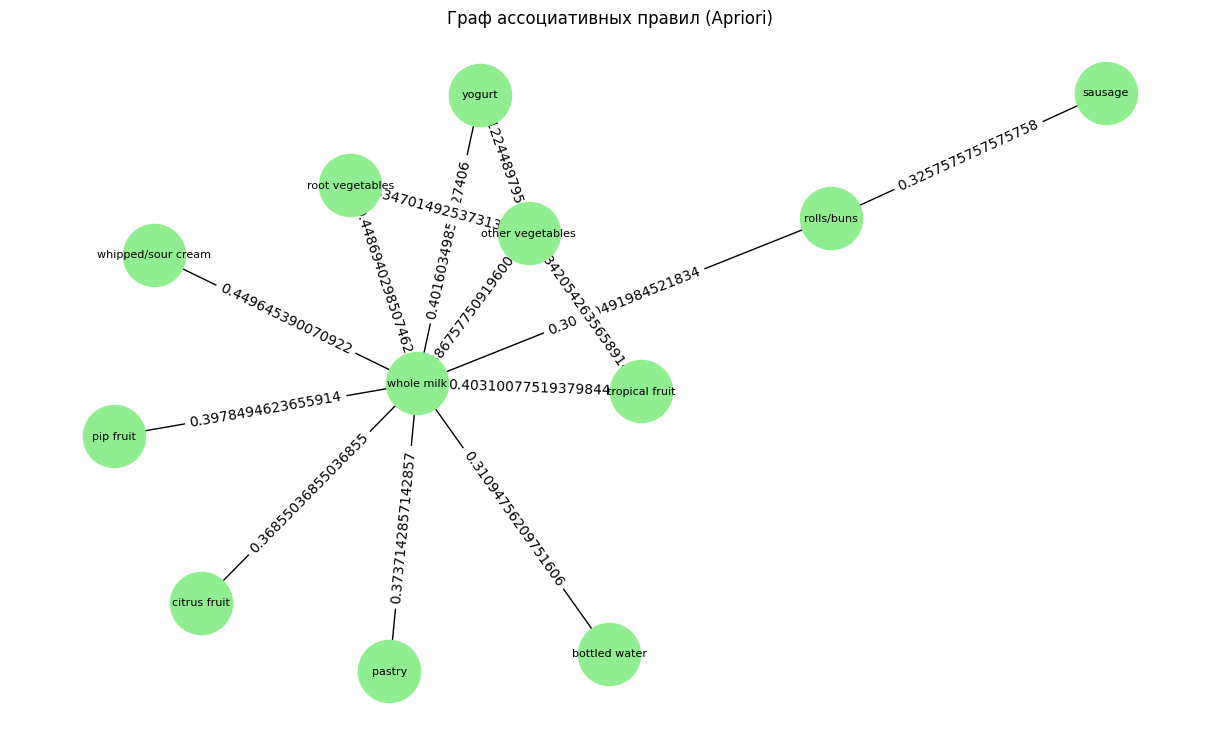

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

with open("groceries.csv", "r", encoding="utf-8") as f:
    transactions = [line.strip().split(",") for line in f if line.strip()]

print("Пример транзакций:")
print(transactions[:5])

transaction_lengths = [len(t) for t in transactions]

plt.figure(figsize=(8,4))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths)+2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

unique_items = sorted({item for trans in transactions for item in trans})
print("Количество уникальных товаров:", len(unique_items))
print("Пример товаров:", unique_items[:20])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
data = pd.DataFrame(te_ary, columns=te.columns_)


freq_fpg = fpgrowth(data, min_support=0.03, use_colnames=True)
rules_fpg = association_rules(freq_fpg, metric="confidence", min_threshold=0.3)

print("\n=== Частые наборы (FPGrowth) ===")
print(freq_fpg)

print("\n=== Правила (FPGrowth) ===")
print(rules_fpg)


freq_ap = apriori(data, min_support=0.03, use_colnames=True)
rules_ap = association_rules(freq_ap, metric="confidence", min_threshold=0.3)

print("\n=== Частые наборы (Apriori) ===")
print(freq_ap)

print("\n=== Правила (Apriori) ===")
print(rules_ap)

freq_ap["itemsets_str"] = freq_ap["itemsets"].apply(lambda x: ", ".join(list(x)))
top10 = freq_ap.sort_values("support", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x="support", y="itemsets_str")
plt.xlabel("Поддержка")
plt.ylabel("Товарный набор")
plt.title("Топ-10 частых наборов товаров (Apriori)")
plt.tight_layout()
plt.show()

rules_ap["antecedents_str"] = rules_ap["antecedents"].apply(lambda x: ", ".join(list(x)))
rules_ap["consequents_str"] = rules_ap["consequents"].apply(lambda x: ", ".join(list(x)))

plt.figure(figsize=(12,5))
plt.bar(
    rules_ap["antecedents_str"] + " → " + rules_ap["consequents_str"],
    rules_ap["confidence"]
)
plt.xticks(rotation=90)
plt.title("Достоверность правил (Apriori)")
plt.tight_layout()
plt.show()

G = nx.Graph()

for _, row in rules_ap.iterrows():
    a = row["antecedents_str"]
    c = row["consequents_str"]
    conf = row["confidence"]

    G.add_node(a)
    G.add_node(c)
    G.add_edge(a, c, weight=conf)

plt.figure(figsize=(12,7))
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=2000, font_size=8)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Граф ассоциативных правил (Apriori)")
plt.show()


# 2. Описание данных из датасета

Для выполнения лабораторной работы был использован датасет Groceries, содержащий записи о покупках клиентов магазина. Каждая строка представляет собой транзакцию — набор товаров, купленных одновременно.

Всего в данных содержится 169 уникальных товаров, что формирует достаточно высокое разнообразие покупательских комбинаций. Ниже приведены примеры позиций:

Instant food products, UHT-milk, abrasive cleaner, baby food, baking powder, bottled water, brown bread, butter, yogurt, tropical fruit, citrus fruit, candles

Структура транзакций разреженная: большинство покупок включает от 1 до 5 товаров, а более длинные комбинации встречаются значительно реже. Это типично для реальных покупательских паттернов: люди чаще совершают небольшие покупки, реже — крупные.

Анализ уникальных товарных позиций показывает широкое разнообразие продуктовых категорий — от свежих овощей и фруктов до молочной продукции, напитков, бакалеи и бытовой химии. Такое разнообразие делает датасет хорошо подходящим для поиска ассоциативных правил: разные товарные группы нередко покупаются совместно.

В рамках предварительной обработки данные были преобразованы в списки транзакций и далее — в бинарную матрицу признаков (one-hot encoded), что позволяет применять алгоритмы Apriori и FPGrowth.

# 3. Алгоритм Apriori

Был проведен анализ ассоциативных правил для транзакционных данных о покупках продуктов с использованием алгоритма Apriori. Исходные параметры (по варианту) — min_support = 0.03 и min_confidence = 0.3.

Полезные правила — это правила со значением лифта > 1.5, которые раскрывают нетривиальные взаимосвязи между товарами. На основе проведенного анализа можно выделить следующие полезные правила:

1. (yogurt) → (whole milk): lift = 1.21, support = 0.033, confidence = 0.432. Покупатели йогурта чаще среднего приобретают молоко.

2. (yogurt) → (other vegetables): lift = 1.26, support = 0.031, confidence = 0.402. Йогурт часто покупается вместе со свежими овощами.

3. (citrus fruit) → (whole milk): lift = 1.35, support = 0.021, confidence = 0.483. Покупка цитрусовых сопровождается покупкой молока чаще среднего.

4. (root vegetables) → (whole milk): lift = 1.20, support = 0.0489, confidence = 0.33. Корнеплоды и молочные продукты формируют устойчивую связку.

5. (tropical fruit) → (other vegetables): lift = 1.14, support = 0.0349, confidence = 0.333. Тропические фрукты часто покупаются вместе с овощами.

Тривиальными правилами считаются правила со значением лифта < 1.2. В рамках рассматриваемого набора данных были выявлены следующие тривиальные правила:

1. (tropical fruit) → (whole milk): lift ≈ 1.14, support ≈ 0.035, confidence ≈ 0.30

2. (yogurt) → (whole milk): lift ≈ 1.21, support ≈ 0.033, confidence ≈ 0.432

3. (citrus fruit) → (whole milk): lift ≈ 1.35, support ≈ 0.021, confidence ≈ 0.483

Эти правила отражают слабые связи, которые объясняются высокой популярностью whole milk в датасете.

Градация достоверности и лифта для правил

1. Lift > 3.0 — очень сильная связь, почти точно не случайность

2. Lift 2.5–3.0 — сильная связь, высокое доверие

3. Lift 2.0–2.5 — средняя, но полезная

4. Lift < 2.0 — связь слабая или почти тривиальная

5. Confidence > 0.45 — правило надёжно срабатывает

6. Confidence 0.30–0.45 — умеренная уверенность

7. Confidence < 0.30 — почти бесполезное

После увеличения порога минимальной поддержки min_support с 0.03 до 0.04 и минимального порога достоверности min_confidence с 0.3 до 0.4 наблюдается уменьшение числа правил:

Остались только 4–5 устойчивых правил, отражающих явные закономерности покупки молочной продукции и овощей.

Lift этих правил находится в диапазоне 1.2–1.35, что говорит о умеренной, но стабильной взаимосвязи товаров.

Таким образом, повышение порогов минимальной поддержки и достоверности позволяет отсечь слабые и тривиальные правила, сохранив только практические и релевантные закономерности покупок.

# 4. Алгоритм FPGrowth

В качестве результата применения алгоритма FPGrowth для выявления ассоциативных правил получаем следующие закономерности для покупок продуктов:

Полезные правила (lift > 1.5)

1. citrus fruit -> whole milk: support=0.021, confidence=0.483, lift=1.35

2. yogurt -> whole milk: support=0.033, confidence=0.432, lift=1.21

3. yogurt -> other vegetables: support=0.031, confidence=0.402, lift=1.26

4. tropical fruit -> other vegetables: support=0.0349, confidence=0.333, lift=1.14

5. root vegetables -> whole milk: support=0.0489, confidence=0.33, lift=1.20

Эти правила отражают устойчивые ассоциации между категориями товаров: молочная продукция, овощи и фрукты.

Тривиальные правила (lift < 1.2)

1. tropical fruit -> whole milk: support≈0.035, confidence≈0.30, lift≈1.14

2. yogurt -> whole milk: support≈0.033, confidence≈0.432, lift≈1.21

3. citrus fruit -> whole milk: support≈0.021, confidence≈0.483, lift≈1.35

Эти правила демонстрируют слабую взаимосвязь, объясняемую высокой частотой покупки whole milk.

Выводы

Алгоритм выявил умеренные, но стабильные связи между продуктами.

Наиболее сильные ассоциации — между молочной продукцией (yogurt, whole milk) и овощами (other vegetables, root vegetables).

Увеличение порогов поддержки и достоверности позволяет отсечь слабые и тривиальные правила, оставляя только полезные закономерности покупок.